In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from ast import literal_eval
import matplotlib.pyplot as plt

# Functions for Pipeline

In [122]:
def drop_categories(df):
    # this function drops all categories of API output which are irrelevant for prediction
    
    # delete unused columns
    df.drop(["dlc", "review_score_desc", "legal_notice", "recommendations", "ext_user_account_notice", "reviews", "metacritic", "demos", 
            "drm_notice", "alternate_appid", "screenshots", "movies", "support_info", "background", "background_raw", 
            "content_descriptors", "packages", "package_groups", "num_reviews", "developers", "achievements", 
            "detailed_description", "about_the_game", "supported_languages", "header_image", "website", 
            'appid', 'name', 'review_score', 'total_negative',
        'type', 'is_free', 'short_description',
       'pc_requirements', 'mac_requirements', 'linux_requirements',
       'publishers','controller_support', 'fullgame' 
            ], axis = 1, inplace=True)
    
    # unwanted genres
    gens = ['Design & Illustration', 'Audio Production', 'Photo Editing', 'Video Production', 'Game Development', 'Software Training',
                'Web Publishing', 'Animation & Modeling', 'Utilities']
    
    # german genres/categories
    german = ['Abenteuer', 'Aktion', 'Volle Controllerunterstützung', 'Steam-Errungenschaften', 'Einzelspieler', 'Remote Play auf Tablets',
              'Steam-Sammelkarten', 'Untertitel verfügbar', 'Plattformübergreifender Mehrspieler', 'Rollenspiel', 'Simulationen', 'Mehrspieler',
              'Online-Koop', 'Teilweise Controllerunterstützung', 'Koop']
    
    #remove rows of russian, german and unwanted genres
    df.drop(df[df[german + gens].isin([1]).any(axis=1)].index, inplace=True)

    # remove cols of russian, german and unwanted genres
    df.drop(german + gens, axis = 1, inplace=True)
    
    '''
    # delete unused categories
    df.drop(['Partial Controller Support', 'Captions available', 'Remote Play on Phone',  'Steam Turn Notifications', 'Steam Trading Cards',
            'Remote Play on TV', 'Includes Source SDK', 'SteamVR Collectibles', 'Commentary available', 'Includes level editor', 
            'Tracked Controller Support',  'Steam Workshop', 'Additional High-Quality Audio', 'Steam Cloud', 'Remote Play on Tablet'
            ], axis = 1, inplace=True)
            
            # russion genres/categories
    russian = ['Экшены','Бесплатно', 'Дизайн и иллюстрация', 'Создание видео', 'Анимация и моделирование', 'Многопользовательские игры', 
              'Приключенческие игры', 'Стратегии', 'Контроллер (полностью)',  'Remote Play на телевизоре', 'Достижения Steam',  'Для нескольких игроков', 'Статистика', 'Коллекционные карточки', 
            'Покупки внутри приложения','Remote Play на телефоне', 'Мастерская Steam', 'Имеется античит Valve', 'Remote Play на планшете', 'Против игроков (по сети)',
            'Против игроков']
'''

In [123]:
def drop_few_review_games(df, num_reviews):
    # drop games with less than num_reviews reviews. also reset the index after dropping rows
    df =  df.loc[lambda df: df['total_reviews'] >= num_reviews, :]
    return df

In [124]:
def drop_high_price_games(df, max_price=200):
    # drops few outlier games which have unreasonably high prices. max price is price in euros (price/100)
    df=  df.loc[lambda df: df.price_overview/100 <= max_price, :]
    return df

In [125]:
def clean_col(df, col):
    # this function takes the API output of the column col categories and cleans it up
    # categories are shown in a list in new column "col_clean" in output dataframe
    
    # iterate through rows
    for index, row in df.iterrows():
        
        # prefilter games without price dict
        if col == "price_overview" and row.is_free:
            df[col].loc[index] = 0
        
        # try to read the entry as a dictionary
        try:
            dict = literal_eval(str(row[col]).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
        
        # if possible
        else:
            
            # get price
            if col == "price_overview":
                
                # if currency is not EUR
                if dict["currency"] != "EUR":
                    
                    # delete row
                    df.drop(index, inplace=True)
            
                # get price
                else:
                    df[col].loc[index] = dict["initial"]
            
            # or relase date
            elif col == "release_date":
        
                if dict['date'] == None:
                    df.drop(index, inplace=True)
                
                else:
                    #if exists, get year of release for game
                    df[col].loc[index] = dict["date"][-4:]
            # or                    
            else:
                categories = []
                
                # get platforms
                if col == "platforms":
                    categories = list({k: v for k, v in dict.items() if v}.keys())
                
                # or get categories/genres 
                else:
                    for j in range(len(dict)):
                        categories.append(dict[j]["description"])
                
                # insert values
                df[col].loc[index] = np.array(categories)
    
    return df

In [126]:
def get_set(df, col):
    # this function iterates through the new column "genres_clean" and return the set of unique genres contained in the dataframe
    G = []
    
    for idx,row in df.iterrows():
        
        for j in range(len(row[col])):
            G.append(row[col][j])
    
    return list(set(G))
        

In [127]:
def one_hot_encode(df, G, col):
    # this function creates a new column for each unique genre in the dataframe to one-hot-encode it.
    for j in G:
        df[j] = 0
    
    for idx,row in df.iterrows():
       for category in row[col]:
           df[category].loc[idx] = 1
    
    # drop old column
    df.drop(col, axis = 1, inplace=True)
    
    return df

In [128]:
def add_score(df):
    df["score"] = df["total_positive"]/df["total_reviews"]
    df.drop(["total_positive", "total_reviews"], axis = 1, inplace = True)
    df.reset_index(drop=True, inplace=True)
    return df

# Pipeline

In [129]:
df = pd.read_csv("raw_data.csv", index_col=0, low_memory=False)

In [130]:
df.columns

Index(['appid', 'name', 'num_reviews', 'review_score', 'review_score_desc',
       'total_positive', 'total_negative', 'total_reviews', 'type',
       'required_age', 'is_free', 'detailed_description', 'about_the_game',
       'short_description', 'supported_languages', 'header_image', 'website',
       'pc_requirements', 'mac_requirements', 'linux_requirements',
       'developers', 'publishers', 'price_overview', 'packages',
       'package_groups', 'platforms', 'categories', 'genres', 'screenshots',
       'movies', 'release_date', 'support_info', 'background',
       'background_raw', 'content_descriptors', 'controller_support',
       'achievements', 'legal_notice', 'recommendations', 'fullgame',
       'ext_user_account_notice', 'reviews', 'metacritic', 'demos', 'dlc',
       'drm_notice', 'alternate_appid'],
      dtype='object')

In [131]:
# clean and pre-process data

df = drop_few_review_games(df, num_reviews=50)

df = clean_col(df, "price_overview")
df = drop_high_price_games(df, max_price=200)

df = clean_col(df, "genres")
genre_set = get_set(df, "genres")
df = one_hot_encode(df, genre_set, "genres")

df = clean_col(df, "categories")
category_set = get_set(df, "categories")
df = one_hot_encode(df, category_set, "categories")

drop_categories(df)

df = clean_col(df, "platforms")
platform_set = get_set(df, "platforms")
df = one_hot_encode(df, platform_set, "platforms")

df = clean_col(df, "release_date")

df = add_score(df)

df.rename(columns={"price_overview": "price", 'release_date': "relase_year"}, inplace = True)


/Users/emilbreustedt/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [132]:
df

,required_age,price,relase_year,Early Access,Indie,Education,Massively Multiplayer,Action,RPG,Nudity,...,Steam Workshop,Valve Anti-Cheat enabled,Full controller support,Additional High-Quality Audio,Online PvP,Remote Play Together,windows,mac,linux,score
0,0,1379,2021,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.955032
1,0,399,2021,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.733668
2,0,499,2021,0,1,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0.921053
3,0,5999,2022,0,0,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0.953191
4,0,799,2021,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.971429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,599,2017,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,1,1,0.921875
9996,0,1679,2020,1,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0.660407
9997,0,4999,2020,0,0,0,0,1,1,0,...,0,0,1,0,1,1,1,0,0,0.677665
9998,0,1999,2017,0,1,0,0,1,1,0,...,0,0,1,0,0,1,1,1,0,0.973799


In [133]:
df.columns

Index(['required_age', 'price', 'relase_year', 'Early Access', 'Indie',
       'Education', 'Massively Multiplayer', 'Action', 'RPG', 'Nudity',
       'Adventure', 'Strategy', 'Gore', 'Casual', 'Sexual Content',
       'Simulation', 'Free to Play', 'Violent', 'Sports', 'Racing',
       'Cross-Platform Multiplayer', 'Downloadable Content', 'MMO',
       'Steam Trading Cards', 'Includes level editor', 'Commentary available',
       'Tracked Controller Support', 'SteamVR Collectibles',
       'Includes Source SDK', 'Partial Controller Support', 'Online Co-op',
       'Single-player', 'PvP', 'Shared/Split Screen Co-op', 'LAN PvP',
       'VR Only', 'Steam Achievements', 'Remote Play on Tablet', 'Co-op',
       'VR Supported', 'VR Support', 'Multi-player', 'Captions available',
       'Remote Play on Phone', 'Steam Cloud', 'Shared/Split Screen PvP',
       'Stats', 'LAN Co-op', 'In-App Purchases', 'Shared/Split Screen',
       'Steam Turn Notifications', 'Steam Leaderboards', 'Remote Play o

In [134]:
df.to_csv('clean_data.csv')
df.sample(1000).to_csv('clean_data_small.csv')

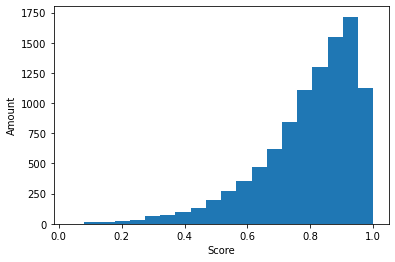

In [135]:
# plot distribution
plt.hist(df.score, bins=20)
plt.xlabel("Score")
plt.ylabel("Amount")

plt.savefig('score_dist.png', dpi=300)

